# Validation - AIS response of models

This notebook evaluates qualitatively the capability of fitted models to reproduce BAC behavior.

In [11]:
import json
import sys
import os
import time
import neuron
from pathlib import Path
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import neuroplotlib as nplt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys
import efel

import LFPy
import neuron
import numpy as np

import shutil

import multimodalfitting as mf

import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cosine

%matplotlib notebook
#%matplotlib widget

In [12]:
base_dir = Path("../..")

In [13]:
colors_dict = {"soma": "C0",
               "all": "C1",
               "sections": "C2",
               "single": "C3"}
figsize = (10, 7)

## Load results and define model

In [14]:
probe_type = "planar"
model_name = "hay_ais" # "hay", "hay_ais", "hay_ais_hillock"
cell_models_folder = base_dir / "cell_models"

model_folder = cell_models_folder / f"{model_name}"

In [15]:
result_dates = [r.name for r in (base_dir / "results").iterdir()]
# use latest results
results_date = max(result_dates)
result_folder = base_dir / "results" / results_date

In [16]:
pkl_file_name = "runs.pkl"

data = pickle.load(open(result_folder / pkl_file_name, 'rb'))
df_optimization = pd.DataFrame(data)
df_model = df_optimization.query(f"model == '{model_name}'")

In [17]:
# # set strategy column
# print(df_model)
# df_model.loc[:, "strategy"] = df_model["strategy"].values.copy()
# df_model.loc[df_model["strategy"] == "soma", "strategy"] = "soma"

In [18]:
protocols_file = model_folder / "fitting" / "efeatures" / "protocols_BPO_all.json"
features_file = model_folder / "fitting" / "efeatures" / "features_BPO_all.json"

In [19]:
ais_recordings = mf.utils.get_ais_extra_recordings()
protocol_for_eap = "IDrest_300"

In [20]:
extra_kwargs = mf.utils.get_extra_kwargs()

In [21]:
cell = mf.create_ground_truth_model(model_name=model_name, release=False)
cell_release = mf.create_ground_truth_model(model_name=model_name, release=True)

probe = mf.define_electrode(probe_type=probe_type)
# probe=None

param_names = [param.name for param in cell.params.values() if not param.frozen]
sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe, mechanisms_directory=model_folder)

fitness_protocols = mf.define_protocols(
    model_name,
    feature_file=features_file,
    protocols_file=protocols_file,
    electrode=probe,
    protocols_with_lfp=[protocol_for_eap],
    extra_recordings={protocol_for_eap: ais_recordings}
)

params_release = {}
for param in cell_release.params_by_names(param_names):
    params_release[param.name] = param.value

# Test AIS dynamics

In [29]:
def simulate_responses(cell, params, sim, protocols, protocol_name="IDrest_300", **extra_kwargs):
    response = protocols[protocol_name].run(cell, params, sim=sim)
    eap = mf.calculate_eap(responses=response, protocols=protocols, 
                           protocol_name=protocol_name, **extra_kwargs)
    return response, eap

In [23]:
opt_results = {}
for strategy in np.unique(df_model.strategy):
    opt_results[strategy] = {}
    opt_df = df_model.query(f"strategy == '{strategy}'")
    best_idx = np.argmin(opt_df.best_fitness)
    params_sample = opt_df.iloc[best_idx]
    params_dict = {k: v for k, v in zip(param_names, params_sample.best_params)}
    opt_results[strategy]["best_fitness"] = params_sample.best_fitness
    opt_results[strategy]["best_params"] = params_dict
    print(f"{strategy} --  best fitness: {params_sample.best_fitness}")

all --  best fitness: 33.26508045278052
sections --  best fitness: 53.31508500534686
single --  best fitness: 829.2264557737103
soma --  best fitness: 47.44035814402742


In [24]:
ms_after = 10
ms_before = 3

In [30]:
print("Computing release")
responses_release, eap_release = simulate_responses(cell, params_release, sim, fitness_protocols, 
                                                    protocol_name=protocol_for_eap, **extra_kwargs)
responses_cut_release = mf.utils.get_peak_cutout(responses_release, ms_before=ms_before, 
                                                 ms_after=ms_after, average=True)

for strategy in np.unique(df_model.strategy):
    print(f"Computing {strategy}")
    best_params = opt_results[strategy]["best_params"]

    responses, eap = simulate_responses(cell, best_params, sim, fitness_protocols, 
                                        protocol_name=protocol_for_eap, **extra_kwargs)
    opt_results[strategy]["responses"] = responses
    responses_cut = mf.utils.get_peak_cutout(responses, ms_before=ms_before, 
                                             ms_after=ms_after, average=True)
    opt_results[strategy]["responses_cut"] = responses_cut
    

Computing release
Computing all
Computing sections
Computing single
Computing soma


In [31]:
responses_to_plot = ['IDrest_300.soma.v', 
                     'IDrest_300.ais_mid_v.v', 
                     'IDrest_300.ais_end_v.v']

<IPython.core.display.Javascript object>


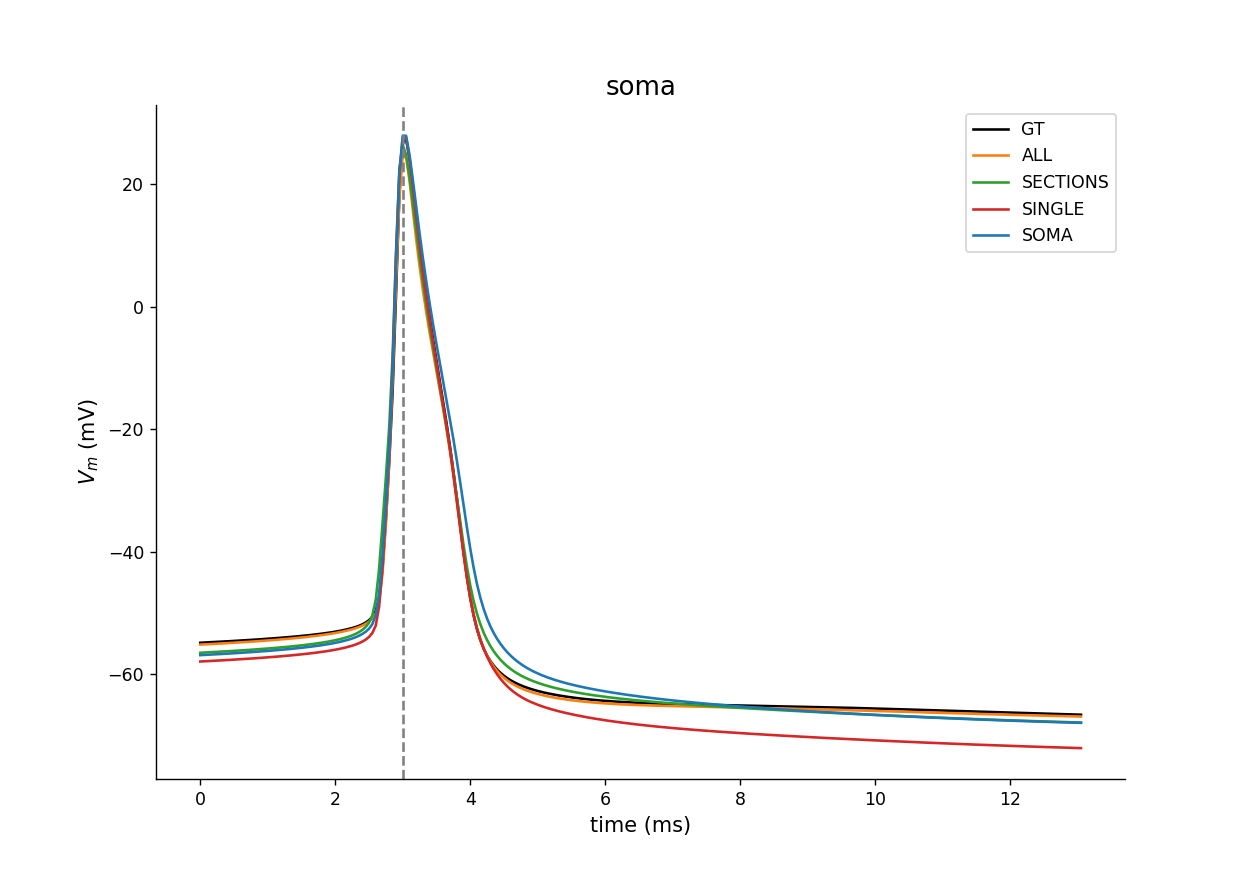

<IPython.core.display.Javascript object>


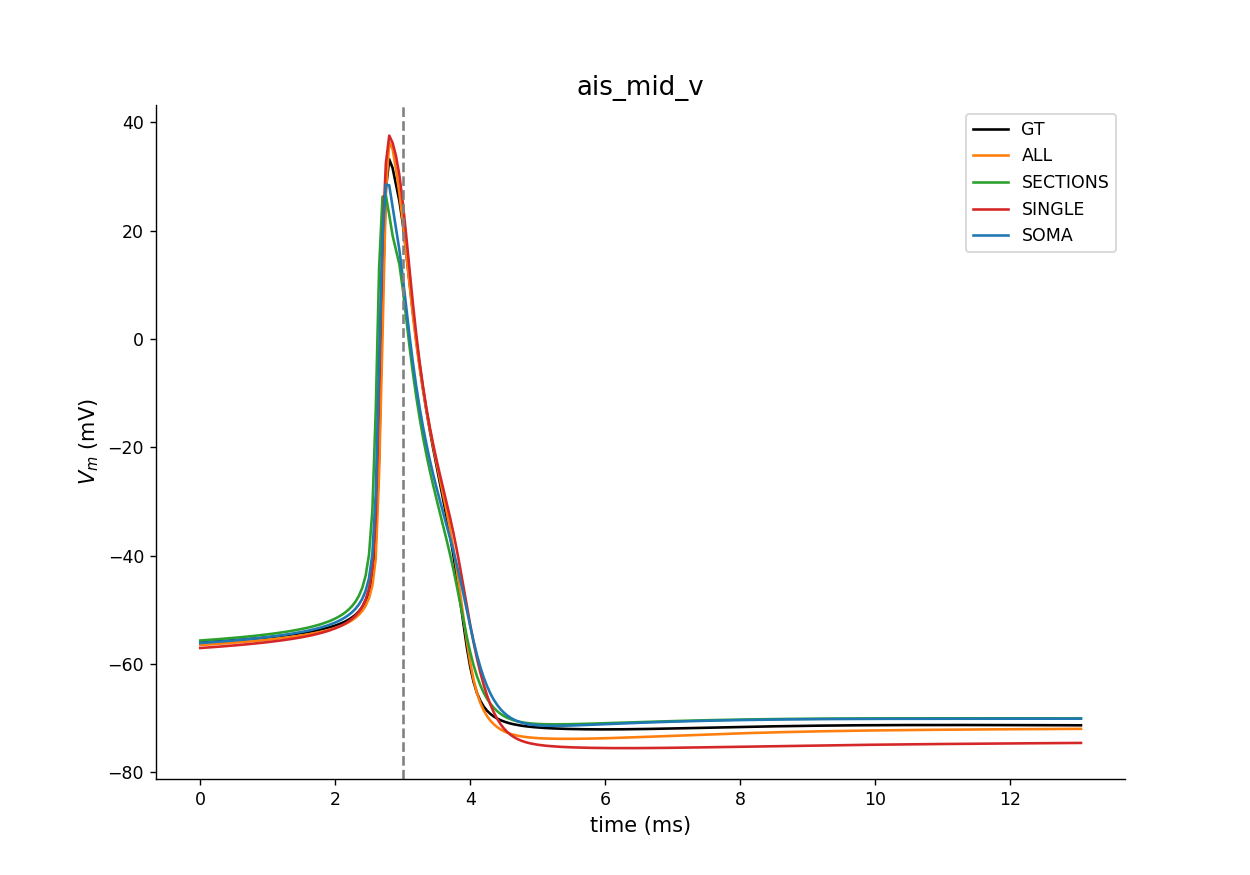

<IPython.core.display.Javascript object>


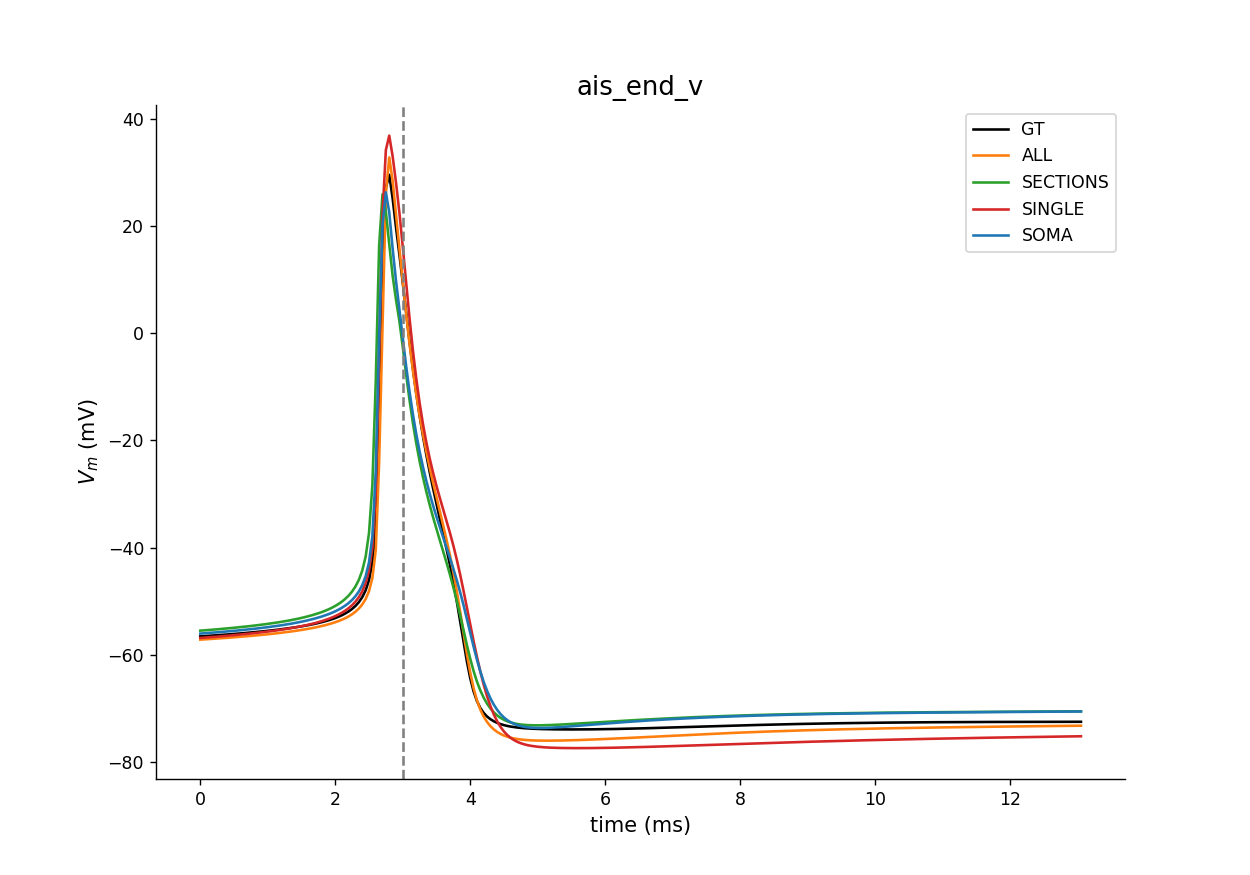

In [32]:
distance_arr = []
strategy_arr = []
position_arr = []
for resp_name in responses_to_plot:
    fig, ax = plt.subplots(figsize=figsize)
    position = resp_name.split(".")[1]
    ax.plot(responses_cut_release[resp_name]["time"], responses_cut_release[resp_name]["voltage"], 
            color="k", label="GT")
    for strategy in opt_results:
        resp_cut = opt_results[strategy]["responses_cut"]
        ax.plot(resp_cut[resp_name]["time"], resp_cut[resp_name]["voltage"], 
                color=colors_dict[strategy], label=strategy.upper())
        dist = cosine(responses_cut_release[resp_name]["voltage"],
                      resp_cut[resp_name]["voltage"])
        position_arr.append(position)
        distance_arr.append(dist)
        strategy_arr.append(strategy)
    ax.set_xlabel("time (ms)", fontsize=12)
    ax.set_ylabel("$V_m$ (mV)", fontsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(f"{position}", fontsize=15)
    ax.axvline(ms_before, color="gray", ls="--")
    ax.legend()

df = pd.DataFrame({"strategy": strategy_arr, "distance": distance_arr, "position": position_arr})

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=df, x="strategy", y="distance", hue="position", ax=ax)
ax.set_xlabel("Strategy", fontsize=12)
ax.set_ylabel("cos. dist.", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title(f"Response distances", fontsize=15)